# Data Acquisition and Feature Engineering

In [6]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np

# Download historical stock data for Apple Inc.
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")

# Feature Engineering:
# Compute daily returns
data['Return'] = data['Close'].pct_change()

# Calculate a 20-day moving average (MA20) and 20-day volatility
data['MA20'] = data['Close'].rolling(window=20).mean()
data['Volatility'] = data['Return'].rolling(window=20).std()

# Drop missing values generated by rolling calculations
data.dropna(inplace=True)

# Define the target variable: bullish if daily return > 0, bearish otherwise
data['Trend'] = np.where(data['Return'] > 0, 'bullish', 'bearish')

# Display the first few rows of the dataset
print(data.tail())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2024-12-24  257.916443  257.926411  255.009620  255.209412  23234700   
2024-12-26  258.735504  259.814335  257.347047  257.906429  27237100   
2024-12-27  255.309296  258.415896  252.782075  257.546826  42355300   
2024-12-30  251.923019  253.221595  250.474615  251.952985  35557500   
2024-12-31  250.144974  253.001833  249.156056  252.162760  39480700   

Price         Return        MA20 Volatility    Trend  
Ticker                                                
Date                                                  
2024-12-24  0.011478  246.023002   0.008828  bullish  
2024-12-26  0.003176  247.219685   0.008782  bullish  
2024-12-27 -0.013242  248.251551   0.009615  bearish  
2024-12-30 -0.013263  248.994234   0.010262  bearish  
2024-12-31 -0.007058  249.535140   0.0

# Building the Baseline Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define features and target variable
features = ['MA20', 'Volatility']
X = data[features]
y = data['Trend']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the Random Forest classifier
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
baseline_predictions = baseline_model.predict(X_test)

# Evaluate the model with accuracy and a classification report
print("Baseline Model Accuracy:", accuracy_score(y_test, baseline_predictions))
print("Baseline Classification Report:\n", classification_report(y_test, baseline_predictions))


Baseline Model Accuracy: 0.44516129032258067
Baseline Classification Report:
               precision    recall  f1-score   support

     bearish       0.39      0.38      0.39       141
     bullish       0.49      0.50      0.49       169

    accuracy                           0.45       310
   macro avg       0.44      0.44      0.44       310
weighted avg       0.44      0.45      0.44       310



#  Plotting a Confusion Matrix

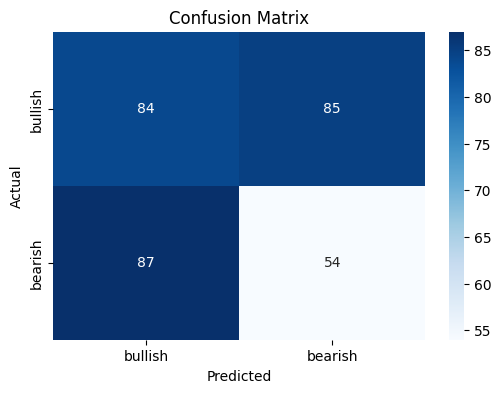

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, baseline_predictions, labels=['bullish', 'bearish'])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['bullish', 'bearish'], yticklabels=['bullish', 'bearish'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Plotting ROC Curve and Calculating AUC

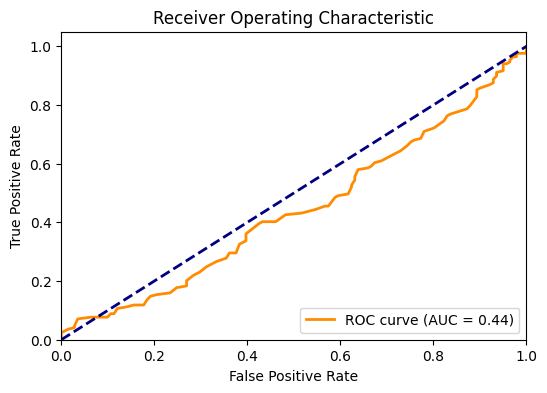

In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Binarize the output for ROC analysis
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
baseline_predictions_prob = baseline_model.predict_proba(X_test)[:, 1]  # probability for 'bullish' class

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binarized, baseline_predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Using Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(baseline_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [0.49596774 0.51612903 0.4233871  0.40080972 0.47773279]
Mean Cross-Validation Accuracy: 0.4628052762178399
